In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2 as cv
from sklearn.cluster import MiniBatchKMeans, KMeans

In [2]:
df_train = pd.read_csv('../../data/external/train.csv')
print(df_train.shape) # (28698, 2305)
df_train.head()

(28698, 2305)


,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 2295,feature 2296,feature 2297,feature 2298,feature 2299,feature 2300,feature 2301,feature 2302,feature 2303,emotion
0,108,83,63,65,89,111,121,121,125,111,...,140,131,121,119,115,111,116,122,122,3
1,137,142,159,162,158,134,113,167,174,177,...,76,98,172,196,192,191,191,192,192,3
2,111,148,155,167,181,191,194,193,195,199,...,152,199,190,121,58,59,57,56,60,3
3,151,156,121,100,80,116,151,169,183,185,...,198,196,197,200,203,205,171,33,32,3
4,248,187,149,130,97,140,139,117,197,251,...,72,69,76,98,123,171,195,200,194,3


In [3]:
df_test = pd.read_csv('../../data/external/test.csv')
print(df_test.shape) # (7177, 2305)
df_test.head()

(7177, 2305)


,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 2295,feature 2296,feature 2297,feature 2298,feature 2299,feature 2300,feature 2301,feature 2302,feature 2303,emotion
0,5,4,5,9,10,9,10,12,8,14,...,9,10,8,9,15,19,17,13,11,3
1,19,21,22,18,20,21,16,18,19,18,...,154,167,166,149,70,46,52,57,49,3
2,228,229,230,229,228,227,226,226,226,221,...,22,29,37,34,29,30,38,30,19,3
3,25,33,43,30,46,84,105,118,139,142,...,166,137,111,125,124,128,127,130,136,3
4,33,29,15,15,20,36,40,54,79,98,...,90,80,81,72,49,43,34,75,78,3


In [4]:
file = '../../data/external/fer2013/train/happy/Training_1206.jpg'

In [12]:
img = cv.imread(file)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)
cv.imwrite('test.jpg',img)

True

In [13]:
sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)

In [56]:
des.shape

(21, 128)

In [35]:
# Data files
train_dir = '../../data/external/fer2013/train'
test_dir = '../../data/external/fer2013/test'
emotions = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'sad':4, 'surprise':5, 'neutral':6}

In [41]:
def sift(image):
    img = cv.imread(file)
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    return des

In [54]:
def extractFeatures():
    test_data = []
    test_des = []
    for dirname, dirs, filenames in os.walk(test_dir, topdown=True):
        cat = dirname.replace(test_dir, '')
        if cat != '':
            cat = cat.replace('/', '')
            for filename in filenames:
                file = os.path.join(dirname, filename)
                descripters = sift(file)
                for i in range(len(descripters)):
                    test_des.append(des[i])
                test_data.append((file, emotions[cat], test_des))
    return test_data

In [55]:
test_data = extractFeatures()
test_data

In [ ]:
test_data

[ WARN:0] global /Users/runner/miniforge3/conda-bld/libopencv_1619749239158/work/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


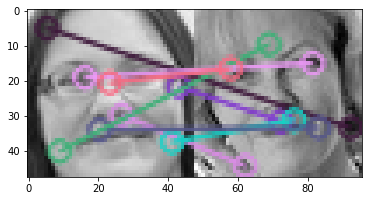

(<matplotlib.image.AxesImage at 0x7fa2b72d4340>, None)

In [23]:
file1 = '../../data/external/fer2013/train/happy/Training_1206.jpg'
file2 = '../../data/external/fer2013/train/happy/Training_143503.jpg'

# read images
img1 = cv2.imread(file1)  
img2 = cv2.imread(file2) 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

In [24]:
matches

[<DMatch 0x7fa2b71c2d10>,
 <DMatch 0x7fa2b71c2e30>,
 <DMatch 0x7fa2b71c2e10>,
 <DMatch 0x7fa2b71c29b0>,
 <DMatch 0x7fa2b71c2b50>,
 <DMatch 0x7fa2b71c2af0>,
 <DMatch 0x7fa2b71c2df0>,
 <DMatch 0x7fa2b71c2cf0>]